In [1]:
# !pip install jiwer -q
# !pip install transformers datasets evaluate -q

In [2]:
from wikimedia import WikipediaAPI
from utils import  clear_dir

# api = WikipediaAPI()
# clear_dir(api.save_path)
# api.get_n_random_images(n=800, split=0.2)

In [3]:
from datasets import load_dataset

dataset = load_dataset("Sigurdur/isl-image-captioning")
train_ds = dataset["train"]
test_ds = dataset["validation"]

Generating train split:   0%|          | 0/640 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/160 [00:00<?, ? examples/s]

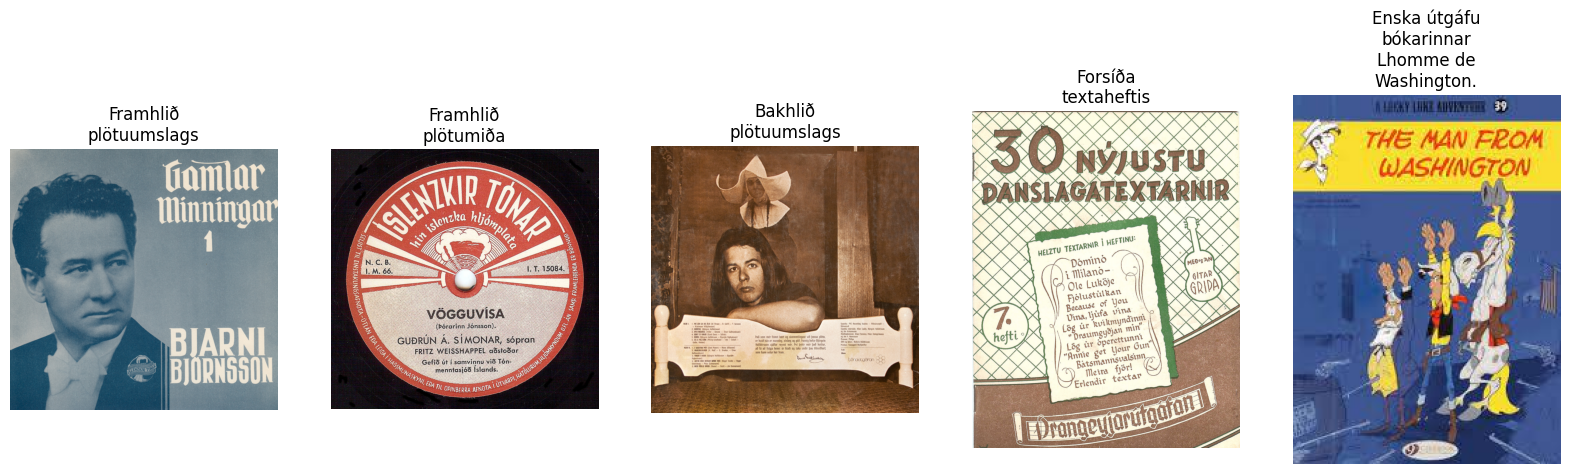

In [4]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

In [5]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

2024-06-29 14:56:04.514217: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-29 14:56:04.911871: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-29 14:56:05.733925: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [7]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

In [8]:
from evaluate import load
import torch

wer = load("wer")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [9]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"isl-img2text",
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=16,
    save_total_limit=3,
    eval_strategy="epoch",
    eval_steps=50,
    eval_accumulation_steps = 16,
    save_strategy="steps",
    save_steps=50,
    logging_steps=10,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.push_to_hub()

[2024-06-29 14:56:15,577] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/haukur/miniconda3/compiler_compat/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.1
 [WARNING]  using untested triton version (2.1.0), only 1.0.0 is known to be compatible


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sigurdurhaukur (sigurdurhaukur-team). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


: 

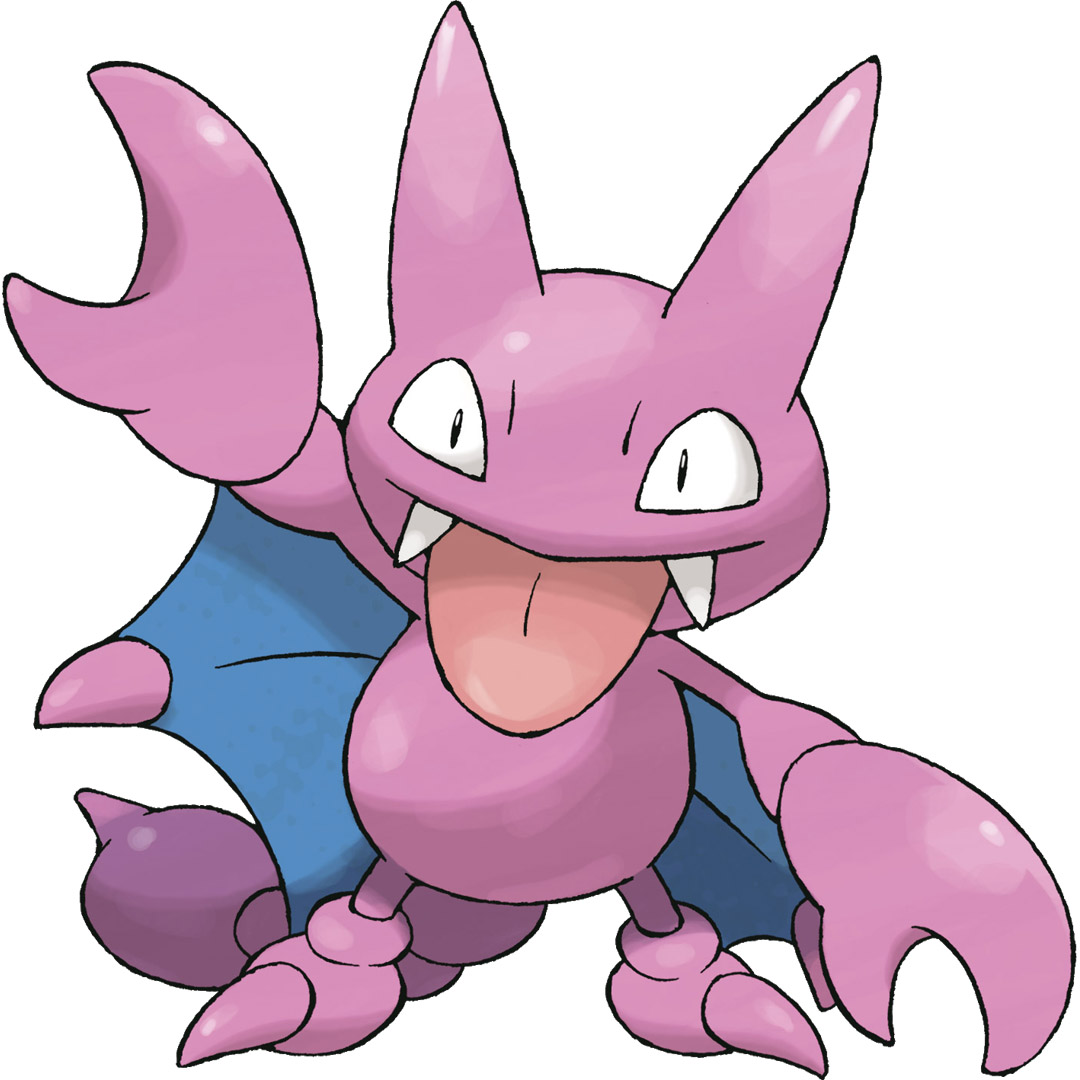

In [ ]:
from PIL import Image
import requests

url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

In [ ]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

gum a. j. bounni bounni bounni bounni bounni bounni bounni bounni bos
